In [1]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os, sys
# asumiendo que iris.ipynb está en notebooks/, y somJ/ en la carpeta superior:
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
from somJ.som       import *
import somJ.config  as config
from somJ.clustering import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
iris=load_iris()
data=iris.data
y_true=iris.target
n_clusters = np.unique(y_true).size

In [3]:
som = SoM(
    #method='pca',
    input_dim=data.shape[1],
    data=data,
    total_nodes=config.TOTAL_NODES
)
som.train(
    train_data=data,
    learn_rate=config.LEARNING_RATE,
    radius_sq=config.RADIUS_SQ,
    lr_decay=config.LR_DECAY,
    radius_decay=config.RADIUS_DECAY,
    epochs=config.EPOCHS,
    update="online",
    batch_size=config.BATCH_SIZE,
    step=config.STEP,
    save=config.SAVE_HISTORY
)
groups, _ = som_clustering(som.som_map, n_clusters)
bmu_coords = np.array([som.find_winner(x) for x in data])


In [4]:
cluster_map = np.full(som.som_map.shape[:2], -1, dtype=int)  # solo usa (m, n)

for cluster_id, nodes in groups.items():
    for i, j in nodes:
        cluster_map[i, j] = cluster_id

rows, cols = cluster_map.shape

for cluster_id, nodes in groups.items():
    for i, j in nodes:
        cluster_map[i, j] = cluster_id

In [5]:
cluster_map

array([[ 0,  1,  1,  1,  1,  1],
       [ 0,  1,  1,  1,  1,  1],
       [ 0,  0,  1,  1,  1,  1],
       [ 0,  0,  1,  1,  1,  1],
       [ 0,  0,  0,  1,  1,  1],
       [ 0,  0,  0,  0,  1,  1],
       [ 0,  0,  0, 39, 39, 39],
       [ 0,  0, 39, 39, 39, 39],
       [ 0,  0, 39, 39, 39, 39],
       [ 0,  0,  0, 39, 39, 39],
       [ 0,  0,  0, 39, 39, 39],
       [ 0,  0,  0,  0, 39, 39],
       [ 0,  0,  0,  0,  0, 39],
       [ 0,  0,  0,  0, 39, 39],
       [ 0,  0,  0,  0, 39, 39],
       [ 0,  0,  0,  0, 39, 39]])

In [6]:
cluster_ids = np.array([ cluster_map[i, j] 
                         for (i, j) in bmu_coords ])
                         

In [7]:
from collections import Counter

label_map = {}
for k in np.unique(cluster_ids):
    mask = (cluster_ids == k)
    most_common = Counter(y_true[mask]).most_common(1)[0][0]
    label_map[k] = most_common

# Ahora traducimos cada cluster_id a una etiqueta “predicha”:
y_pred_majority = np.array([ label_map[k] for k in cluster_ids ])


 Accuracy: 88.67%


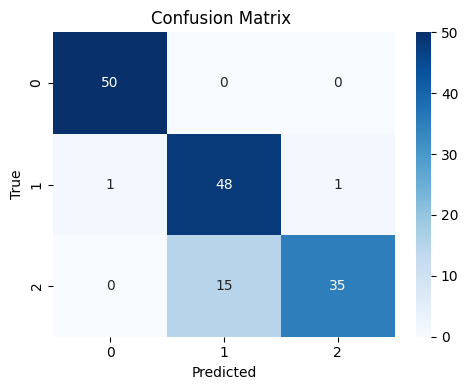

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy = accuracy_score(y_true, y_pred_majority)
cm = confusion_matrix(y_true, y_pred_majority)

print(f" Accuracy: {accuracy:.2%}")
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix ")
plt.tight_layout()
plt.show()


/tmp/ipykernel_241723/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)
/tmp/ipykernel_241723/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)
/tmp/ipykernel_241723/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)
/tmp/ipykernel_241723/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap f

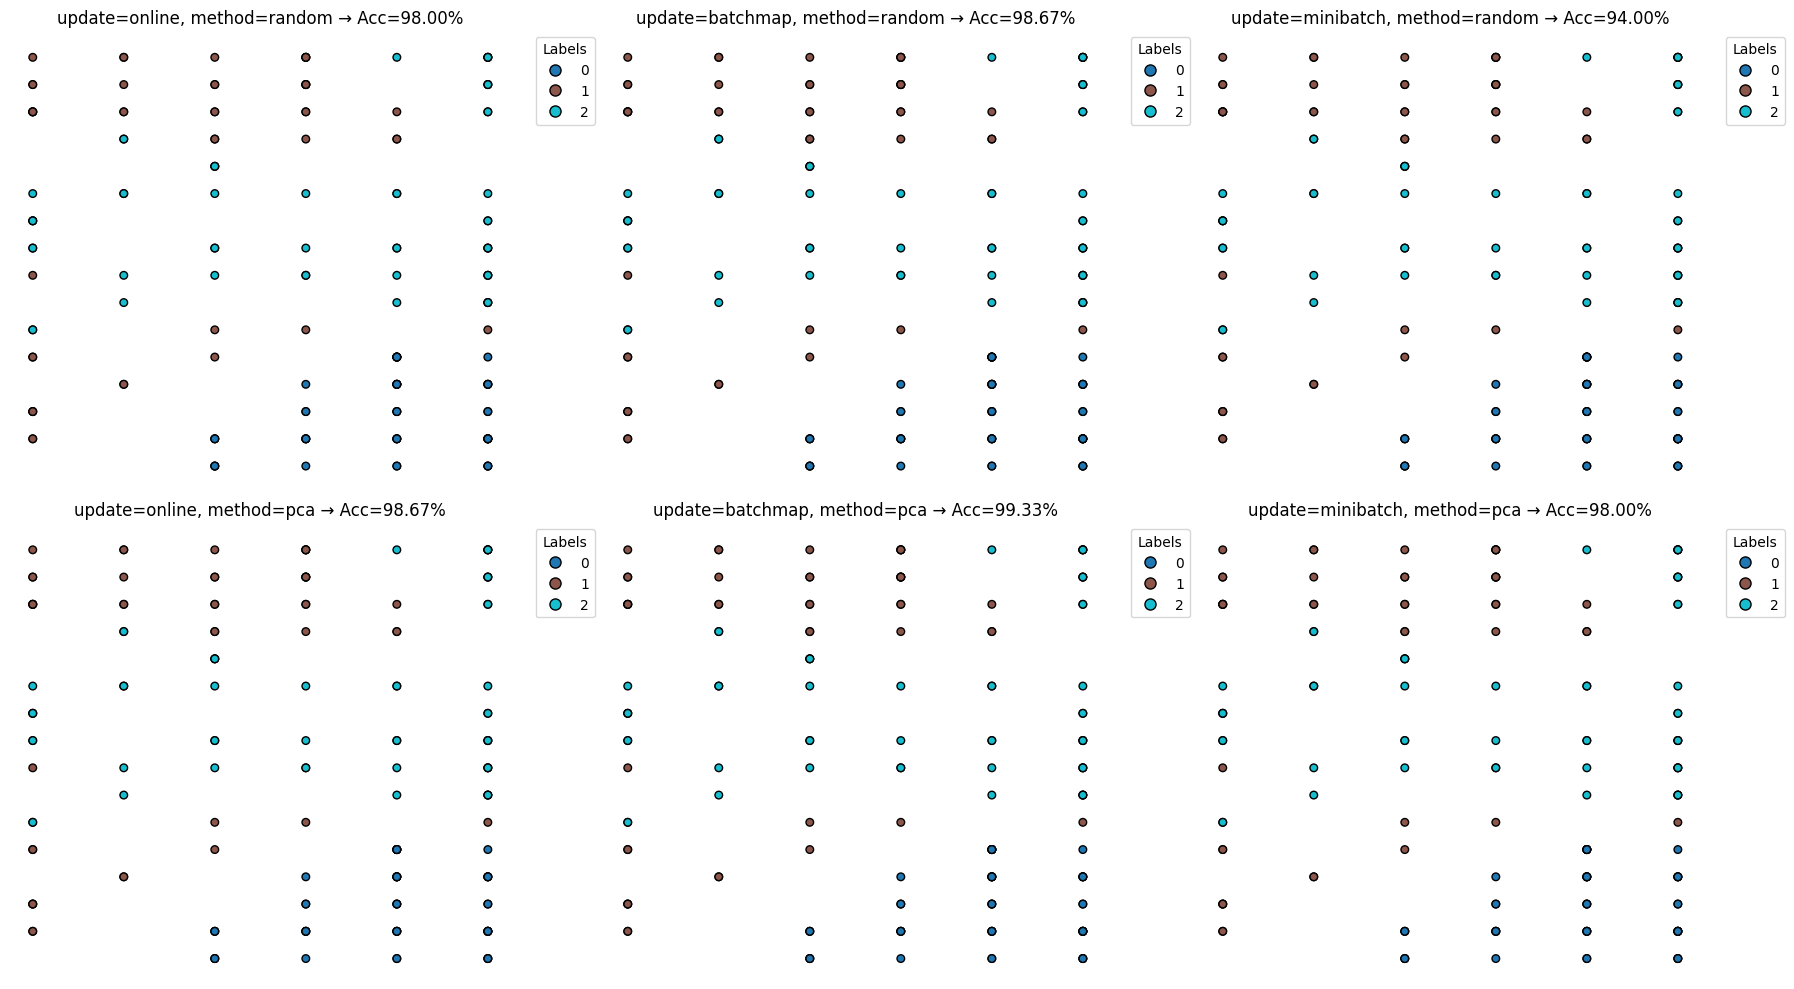

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt

# Parámetros y configuraciones
updates = ["online", "batchmap", "minibatch"]
methods_order = ["random", "pca"]  # fila 0 → random; fila 1 → pca

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
n_clusters = 3  # Asegúrate de definir el número de clusters
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)

for row, mtd in enumerate(methods_order):
    for col, upd in enumerate(updates):
        ax = axes[row, col]

        # 1) Entrena el SOM con esta combinación
        som = SoM(
            method=mtd,
            input_dim=data.shape[1],
            data=data,
            total_nodes=config.TOTAL_NODES
        )
        som.train(
            train_data=data,
            learn_rate=config.LEARNING_RATE,
            radius_sq=config.RADIUS_SQ,
            lr_decay=config.LR_DECAY,
            radius_decay=config.RADIUS_DECAY,
            epochs=config.EPOCHS,
            update=upd,
            batch_size=config.BATCH_SIZE,
            step=config.STEP,
            save=config.SAVE_HISTORY
        )

        y_pred = som.predict(data,y_true)
        acc = accuracy_score(y_true, y_pred)

        # 7) Dibuja en el subplot: fondo + scatter de BMUs + leyenda
        cmap = plt.cm.get_cmap('tab10', n_clusters)
        ax.axis("off")
        ax.set_title(f"update={upd}, method={mtd} → Acc={acc:.2%}", pad=10)

        # Superponer puntos BMU con color de etiqueta verdadera
        xs = bmu_coords[:, 1]
        ys = bmu_coords[:, 0]
        scatter = ax.scatter(xs, ys, c=y_true, cmap=cmap, s=30, edgecolor='k')

        # Añadir leyenda de etiquetas
        unique_labels = np.unique(y_true)
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(lbl),
                              markerfacecolor=cmap(lbl), markersize=8, markeredgecolor='k')
                   for lbl in unique_labels]
        ax.legend(handles=handles, title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Ajuste y muestra
plt.tight_layout()
plt.show()

Precisión SOM (MiniSom): 0.97


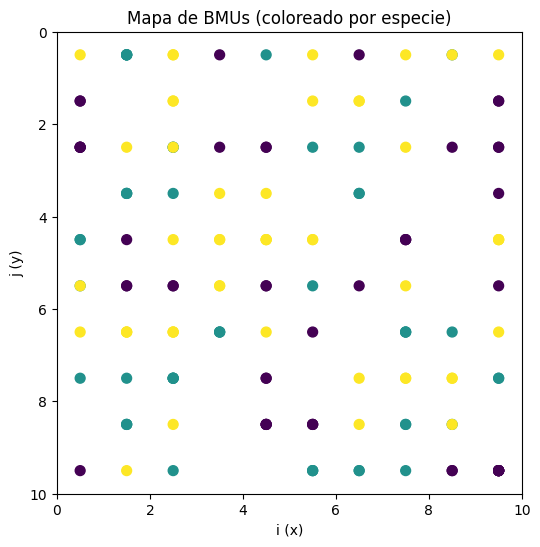

In [10]:
# 1. Instala MiniSom si no lo tienes:
#    pip install minisom

from minisom import MiniSom
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# 2. Carga y escala el dataset
iris = load_iris()
X = iris.data
y = iris.target
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. Crea e inicializa el SOM
#    - tamaño 10×10
#    - dimensión de entrada = 4 (features)
#    - sigma (vecindad) y learning_rate por defecto
som = MiniSom(x=10, y=10, input_len=4, sigma=config.RADIUS_SQ, learning_rate=config.LEARNING_RATE,
              neighborhood_function='gaussian', random_seed=42)
som.random_weights_init(X_scaled)

# 4. Entrena el SOM
som.train_random(data=X_scaled, num_iteration=config.EPOCHS)

# 5. Etiqueta cada unidad con la mayoría de votos
labels_map = {}
for xi, label in zip(X_scaled, y):
    w = som.winner(xi)             # índice (i,j) de la BMU
    labels_map.setdefault(w, []).append(label)

# toma la etiqueta más frecuente por nodo
labels_map = {pos: np.bincount(lbls).argmax() 
              for pos, lbls in labels_map.items()}

# 6. Predicción y precisión
y_pred = np.array([labels_map[som.winner(xi)] for xi in X_scaled])
accuracy = np.mean(y_pred == y)
print(f"Precisión SOM (MiniSom): {accuracy:.2f}")

# 7. Visualización de los BMU en el grid
coords = np.array([som.winner(xi) for xi in X_scaled])
plt.figure(figsize=(6,6))
plt.scatter(coords[:,0]+0.5, coords[:,1]+0.5, c=y, s=50, cmap='viridis')
plt.title('Mapa de BMUs (coloreado por especie)')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.gca().invert_yaxis()
plt.xlabel('i (x)')
plt.ylabel('j (y)')
plt.show()


Fold 1: precisión = 0.97
Fold 2: precisión = 0.90
Fold 3: precisión = 0.87
Fold 4: precisión = 0.97
Fold 5: precisión = 0.93

Precisión media: 0.93 ± 0.04


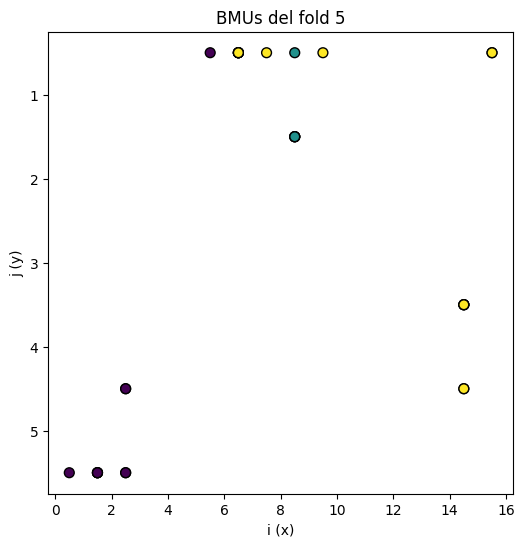

In [11]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Carga y escala
iris = load_iris()
X = iris.data
y = iris.target
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2. Configura el K-fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

scores = []

# 3. Bucle de validación cruzada
for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y), 1):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # 4. Crea y entrena un SOM nuevo para este fold
    som = SoM(
        method=mtd,
        input_dim=X_train.shape[1],
        data=X_train,
        total_nodes=config.TOTAL_NODES
    )
    som.train(
        train_data=X_train,
        learn_rate=config.LEARNING_RATE,
        radius_sq=config.RADIUS_SQ,
        lr_decay=config.LR_DECAY,
        radius_decay=config.RADIUS_DECAY,
        epochs=config.EPOCHS,
        update=upd,
        batch_size=config.BATCH_SIZE,
        step=config.STEP,
        save=config.SAVE_HISTORY
    )

    # 5. Predicción y métrica
    y_pred = som.predict(X_test, y_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)
    print(f"Fold {fold}: precisión = {acc:.2f}")

# 6. Resultado agregado
mean_acc = np.mean(scores)
std_acc  = np.std(scores)
print(f"\nPrecisión media: {mean_acc:.2f} ± {std_acc:.2f}")

# 7. (Opcional) Visualizar BMUs del último fold
coords_test = np.array([som.find_winner(xi) for xi in X_test])
plt.figure(figsize=(6,6))
plt.scatter(coords_test[:,0]+0.5, coords_test[:,1]+0.5,
            c=y_test, s=50, cmap='viridis', marker='o', edgecolor='k')
plt.title(f'BMUs del fold {fold}')
plt.gca().invert_yaxis()
plt.xlabel('i (x)'); plt.ylabel('j (y)')
plt.show()
